<a href="https://colab.research.google.com/github/sfwtopoulos/stocks/blob/master/Stocks_seq_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings
import numpy as np
import time

import pandas_datareader as pdr
#%tensorflow_version 2.x
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
import keras


from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
#not all needed


warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [199]:
print(keras.__version__)
print(tf.__version__)
#print(tensorflow.compat.v2.__version__)

2.2.5
1.15.0


In [0]:
#Data import from git repo
url = 'https://raw.githubusercontent.com/sfwtopoulos/stocks/master/stocks_dataset/combined.csv'
#df1 = pd.read_csv(url, error_bad_lines=False)
dfstocks = pd.read_csv(url, sep=',')

In [201]:
#fix column names
dfstocks=dfstocks.rename({' AAPL':'Company', ' Close/Last':'Close', ' Volume':'Volume', ' Open':'Open', ' High':'High', ' Low':'Low'}, axis=1);
for col in dfstocks.columns: 
    print(col) 

Date
Close
Volume
Open
High
Low
Company


In [0]:
#drop $sign from values
dfstocks.Close=dfstocks['Close'].astype(str)
dfstocks.Close=dfstocks.Close.apply(lambda x: x.replace('$',''))
dfstocks.Open=dfstocks['Open'].astype(str)
dfstocks.Open=dfstocks.Open.apply(lambda x: x.replace('$',''))
dfstocks.High=dfstocks['High'].astype(str)
dfstocks.High=dfstocks.High.apply(lambda x: x.replace('$',''))
dfstocks.Low=dfstocks['Low'].astype(str)
dfstocks.Low=dfstocks.Low.apply(lambda x: x.replace('$',''))

In [203]:
#drop rows containing nan or header from the csv files
dfstocks=dfstocks[~dfstocks.Low.str.contains("nan")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("Low")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("N/A")]
dfstocks=dfstocks[~dfstocks.Volume.str.contains("N/A")]
dfstocks.reset_index(drop=True, inplace=True)
dfstocks.Date.count()

229269

In [204]:
#sort dataframe based on date and Company Name
dfstocks = dfstocks.sort_values(['Date', 'Company'])
dfstocks.head(100)

,Date,Close,Volume,Open,High,Low,Company
1761,01/02/2013,78.4328,139906732,79.1171,79.2857,77.3757,AAPL
4248,01/02/2013,35.12,13767660,34.92,35.4,34.1,ABBV
6025,01/02/2013,32.05,20266410,32.3,32.45,31.64,ABT
8512,01/02/2013,69.06,4039095,67.59,69.06,67.55,ACN
10999,01/02/2013,38.34,6483720,37.92,38.73,37.92,ADBE
...,...,...,...,...,...,...,...
10747,01/02/2014,59.29,2745895,59.06,59.53,58.94,ADBE
13234,01/02/2014,168.05,1268722,167.33,170.71,166.5937,AGN
15721,01/02/2014,50.71,9196092,50.81,51.3,50.47,AIG
18208,01/02/2014,53.55,1909106,54.09,54.45,53.5,ALL


In [0]:
#Test Split
#dfstocks_split = dfstocks.sample(frac=0.9998,random_state=200)
#sub_split=dfstocks.drop(dfstocks_split.index)
# sub_split = sub_split.reindex(index=sub_split.Date(sub_split.index.min(), 
#                                           sub_split.index.max(), 
#                                           freq='D')).fillna(method='ffill')


In [205]:
#Converting Datatypes
dfstocks.Date=pd.to_datetime(dfstocks.Date)
dfstocks.Close=pd.to_numeric(dfstocks.Close)
dfstocks.Volume=pd.to_numeric(dfstocks.Volume)
dfstocks.Open=pd.to_numeric(dfstocks.Open)
dfstocks.High=pd.to_numeric(dfstocks.High)
dfstocks.Low=pd.to_numeric(dfstocks.Low)
dfstocks.dtypes

Date       datetime64[ns]
Close             float64
Volume              int64
Open              float64
High              float64
Low               float64
Company            object
dtype: object

In [206]:
#dfstocks[dfstocks['Company'].str.contains("AMZN")]
sub_split=dfstocks[dfstocks['Company'].str.contains("AIG")]
sub_split.isnull().values.any()
sub_split.isna().values.any()
sub_split = sub_split.sort_values(['Date'])
sub_split.reset_index(drop=True, inplace=True)
sub_split.shape[0]

2487

In [207]:
sub_split

,Date,Close,Volume,Open,High,Low,Company
0,2010-02-16,29.0571,135631411,28.8486,29.0986,28.7886,AAPL
1,2010-02-17,28.9357,108691903,29.1700,29.1871,28.6943,AAPL
2,2010-02-18,28.9897,105298302,28.8043,29.1271,28.7028,AAPL
3,2010-02-19,28.8100,103810451,28.8371,29.0286,28.7300,AAPL
4,2010-02-22,28.6308,97607889,28.9057,28.9286,28.4557,AAPL
...,...,...,...,...,...,...,...
2482,2019-12-24,284.2700,12119710,284.6900,284.8900,282.9197,AAPL
2483,2019-12-26,289.9100,23334000,284.8200,289.9800,284.7000,AAPL
2484,2019-12-27,289.8000,36592940,291.1200,293.9700,288.1200,AAPL
2485,2019-12-30,291.5200,36059610,289.4600,292.6900,285.2200,AAPL


In [0]:
TRAIN_PERCENT = 0.7
#STOCK_INDEX = '^GSPC'
VERBOSE=True

In [0]:
# prepare training and testing data sets for LSTM based sequence modeling
#def get_seq_train_test(time_series, scaling=True,train_size=0.9):
def get_seq_train_test(time_series,train_size=0.9):

    # #scaling of variables to range [0,1]
    # #must scale seperatly or scale only the output variable maybe!??
    # scaler_Close = MinMaxScaler(feature_range=(0, 1))
    # time_series.Close = time_series.Close.values
    # time_series.Close = np.array(time_series.Close).reshape(-1,1)
    # scaler_Close = scaler_Close.fit(time_series.Close)


    # scaler_Volume = MinMaxScaler(feature_range=(0, 1))
    # time_series.Volume = np.array(time_series.Volume).reshape(-1,1)
    # scaler_Volume = scaler_Volume.fit(time_series.Volume)


    # time_series = time_series[[Close,Volume]].values


    # #reshape(-1,1) -1 --> unknown number of rows, 1 --> 1 column
    # #time_series = np.array(time_series).reshape(-1,1)
    # time_series = np.array(time_series).reshape(-1,2)
    # #time_series = np.array(time_series)

    # ##scaled_stock_series = scaler.fit_transform(time_series)

    # time_series = scaled_stock_series

#    print(time_series)

    series1 = pd.Series(time_series[time_series.columns[0]])
    series2 = pd.Series(time_series[time_series.columns[1]])

    values1 = series1.values
    values1 = values1.reshape((len(values1), 1))
    values2 = series2.values
    values2 = values2.reshape((len(values2), 1))

    scaler1 = MinMaxScaler(feature_range=(0, 1))
    #scaler1 = scaler1.fit(values1)
    time_series["scaled1"] = scaler1.fit_transform(values1)
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    #scaler2 = scaler2.fit(values2)
    time_series["scaled2"]= scaler2.fit_transform(values2)

    # time_series["scaled1"] = scaler1
    # time_series["scaled2"] = scaler2



    time_series = time_series[["scaled1","scaled2"]].values

        
    train_size = int(len(time_series) * train_size)

    train = time_series[0:train_size]
    test = time_series[train_size:len(time_series)]
    
    return train,test,scaler1,scaler2


In [0]:
def get_seq_model(hidden_units=4,input_shape=(1,1),verbose=False):
    # create and fit the LSTM network
    model = Sequential()
    # samples*timesteps*featuress
    # https://keras.io/getting-started/sequential-model-guide/
    #relu_advanced=keras.activations.relu(x,)

    model.add(LSTM(input_shape=input_shape,
                   units = hidden_units,  
   #                activation='relu',
                   return_sequences=True
    ))

    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    # model.add(TimeDistributed(Dense(1))) #number of inputs in the 1st layer
    model.add(TimeDistributed(Dense(2)))
   
    start = time.time()
    #softsign
    #model.add(activation='softsign')


    model.compile(loss="mse", optimizer="rmsprop")

    if verbose:
        print("> Compilation Time : ", time.time() - start)
        print(model.summary())

    return model

In [211]:
print(type(sub_split.Close))
sub_split=sub_split[['Volume', 'Close']]
#sub_split.columns[1]

<class 'pandas.core.series.Series'>


In [212]:
# split train and test datasets
train,test,scaler_Volume,scaler_Close = get_seq_train_test(sub_split,train_size=TRAIN_PERCENT)

#train
print(len(train))
print(train.shape[0])
print(train.shape)
print(test.shape)
print(train)

1740
1740
(1740, 2)
(747, 2)
[[0.27549278 0.00341169]
 [0.21577058 0.00295444]
 [0.2082473  0.00315783]
 ...
 [0.04890092 0.34214367]
 [0.02897624 0.34259565]
 [0.03567232 0.34500621]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [213]:
#We use numpy to reshape our time series into 3D tensors.
train = np.reshape(train,(1,train.shape[0],2))
test = np.reshape(test,(1,test.shape[0],2))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 1739, 2)
train_y shape=(1, 1739, 2)
test_x shape=(1, 746, 2)
test_y shape=(1, 746, 2)


In [214]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],2),
                                                verbose=VERBOSE)
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],2),
                                                verbose=VERBOSE)

> Compilation Time :  0.024973392486572266
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1739, 4)           112       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1739, 2)           10        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
None


In [215]:
train_y

array([[[0.21577058, 0.00295444],
        [0.2082473 , 0.00315783],
        [0.20494889, 0.00248099],
        ...,
        [0.04890092, 0.34214367],
        [0.02897624, 0.34259565],
        [0.03567232, 0.34500621]]])

In [293]:
# train the model
seq_lstm_model.fit(train_x, train_y,
                #epochs=20, batch_size=1,
                epochs=250, batch_size=1,
                verbose=2)
print("Model Fit Complete")

Epoch 1/250
 - 1s - loss: 0.0232
Epoch 2/250
 - 1s - loss: 0.0228
Epoch 3/250
 - 1s - loss: 0.0224
Epoch 4/250
 - 1s - loss: 0.0219
Epoch 5/250
 - 1s - loss: 0.0215
Epoch 6/250
 - 1s - loss: 0.0212
Epoch 7/250
 - 1s - loss: 0.0208
Epoch 8/250
 - 1s - loss: 0.0205
Epoch 9/250
 - 1s - loss: 0.0201
Epoch 10/250
 - 1s - loss: 0.0198
Epoch 11/250
 - 1s - loss: 0.0195
Epoch 12/250
 - 1s - loss: 0.0192
Epoch 13/250
 - 1s - loss: 0.0190
Epoch 14/250
 - 1s - loss: 0.0187
Epoch 15/250
 - 1s - loss: 0.0184
Epoch 16/250
 - 1s - loss: 0.0182
Epoch 17/250
 - 1s - loss: 0.0180
Epoch 18/250
 - 1s - loss: 0.0178
Epoch 19/250
 - 1s - loss: 0.0175
Epoch 20/250
 - 1s - loss: 0.0173
Epoch 21/250
 - 1s - loss: 0.0172
Epoch 22/250
 - 1s - loss: 0.0170
Epoch 23/250
 - 1s - loss: 0.0168
Epoch 24/250
 - 1s - loss: 0.0166
Epoch 25/250
 - 1s - loss: 0.0165
Epoch 26/250
 - 1s - loss: 0.0163
Epoch 27/250
 - 1s - loss: 0.0162
Epoch 28/250
 - 1s - loss: 0.0161
Epoch 29/250
 - 1s - loss: 0.0159
Epoch 30/250
 - 1s - lo

In [294]:
# train fit performance
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.06 RMSE


In [295]:
trainPredict

array([[[0.1651239 , 0.00758678],
        [0.19936547, 0.01011102],
        [0.22078681, 0.0094309 ],
        ...,
        [0.06134503, 0.32023236],
        [0.06207259, 0.32248852],
        [0.06023592, 0.32177266]]], dtype=float32)

In [0]:
# Pad input sequence
testPredict = pad_sequences(test_x,maxlen=train_x.shape[1],padding='post',dtype='float64')

In [297]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)
testPredict

array([[[ 0.12173168,  0.010339  ],
        [ 0.13353123,  0.03749001],
        [ 0.14224555,  0.06849603],
        ...,
        [ 0.18097907, -0.05834969],
        [ 0.18097907, -0.05834969],
        [ 0.18097907, -0.05834969]]], dtype=float32)

In [298]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)
testPredict

array([[[ 0.14575544, -0.01155923],
        [ 0.17456934, -0.00787518],
        [ 0.1933126 , -0.00115359],
        ...,
        [ 0.26200444, -0.04829685],
        [ 0.26200444, -0.04829685],
        [ 0.26200444, -0.04829685]]], dtype=float32)

In [299]:
testPredict

array([[[ 0.14575544, -0.01155923],
        [ 0.17456934, -0.00787518],
        [ 0.1933126 , -0.00115359],
        ...,
        [ 0.26200444, -0.04829685],
        [ 0.26200444, -0.04829685],
        [ 0.26200444, -0.04829685]]], dtype=float32)

In [0]:
testPredict=np.delete(testPredict, 0, 2)
trainPredict=np.delete(trainPredict, 0, 2)

In [301]:
trainPredict


array([[[0.00758678],
        [0.01011102],
        [0.0094309 ],
        ...,
        [0.32023236],
        [0.32248852],
        [0.32177266]]], dtype=float32)

In [302]:
type(testPredict)

numpy.ndarray

In [0]:
# # inverse transformation

#scaler = MinMaxScaler(feature_range=(0, 1))
#time_series = np.array(sub_split.Close).reshape(-1,1)
#scaler = scaler.fit(time_series)

#trainPredict=trainPredict.reshape(trainPredict.shape[1])
#testPredict=testPredict.reshape(testPredict.shape[1])


 #scaler = MinMaxScaler(feature_range=(0, 1))

# trainPredict = scaler.inverse_transform(trainPredict.reshape(trainPredict.shape[1]))
# testPredict = scaler.inverse_transform(testPredict.reshape(testPredict.shape[1]))

trainPredict = scaler_Close.inverse_transform(trainPredict.\
                                        reshape(-1,1))
testPredict = scaler_Close.inverse_transform(testPredict.\
                                       reshape(-1,1))


# # inverse transformation
# trainPredict = scaler.inverse_transform(trainPredict.\
#                                         reshape(trainPredict.shape[1],2))
# testPredict = scaler.inverse_transform(testPredict.\
#                                         reshape(testPredict.shape[1],2))

In [304]:
trainPredict

array([[ 30.16558 ],
       [ 30.835762],
       [ 30.655191],
       ...,
       [113.17258 ],
       [113.77158 ],
       [113.58152 ]], dtype=float32)

In [305]:
sub_split_date=dfstocks[dfstocks['Company'].str.contains("AAPL")]
sub_split_date.isnull().values.any()
sub_split_date.isna().values.any()
sub_split_date = sub_split_date.sort_values(['Date'])
sub_split_date.reset_index(drop=True, inplace=True)
sub_split_date.shape[0]

2487

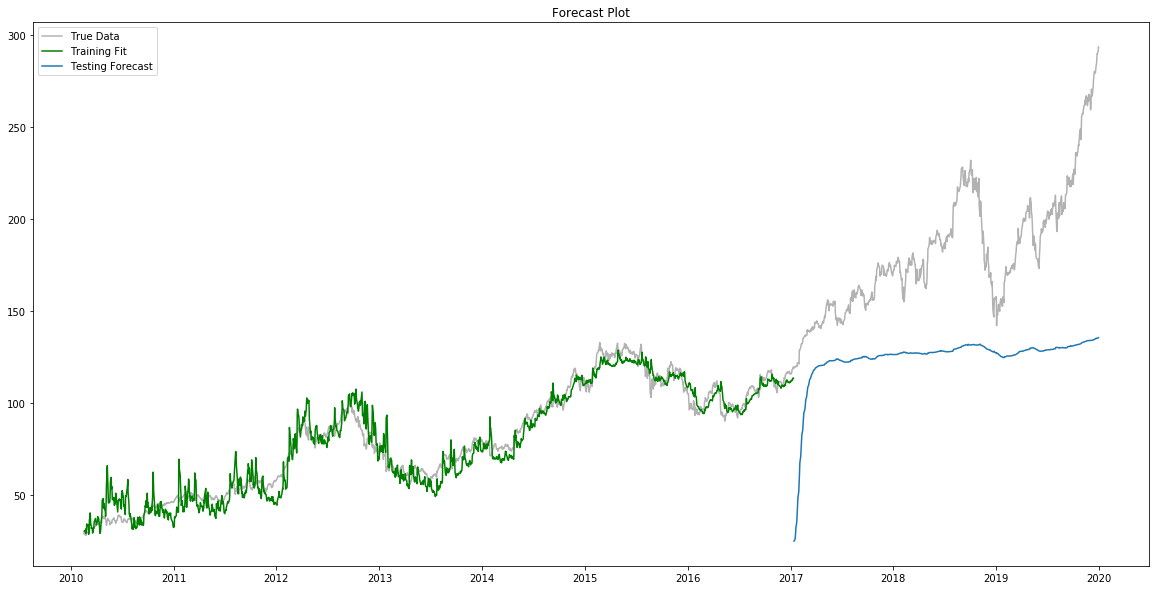

In [306]:
# plot the true and forecasted values
train_size = len(trainPredict)+1
#sub_split.Date.dt.year
# plt.plot(sub_split.index,
#           sub_split.Close.values,c='black',
#           alpha=0.3,label='True Data')
plt.plot(sub_split_date.Date,
          sub_split.Close.values,c='black',
          alpha=0.3,label='True Data')
# # multipl /500000
# trainPredict = scaler_Volume.inverse_transform(trainPredict.\
#                                         reshape(-1,2))

plt.plot(sub_split_date.Date[1:train_size],
          trainPredict,label='Training Fit',c='g')
# #mulitple /100000
plt.plot(sub_split_date.Date[train_size+1:],
          testPredict[:test_x.shape[1]],label='Testing Forecast')
plt.title('Forecast Plot')
plt.legend()
plt.show()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()